In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from datetime import date, datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn import metrics   
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import scipy.stats as stats
import os
import pickle
import pandas as pd
os.chdir('../util')
from util import scores_df
from util import iqr_exclude
%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2

load_data = 0
rextract = 0
retrain = 1
# Load data
# fig,ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
if load_data == 1:
    for filename in os.listdir(directory):
        f = os.path.join(directory,filename)
        print(f)
    
        seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
                    
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())

        qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
        qsms.append(qsm.get_fdata())
            
        case_list.append(filename)
        n_cases = len(segs)

        label_min = np.partition(np.unique(seg.get_fdata().ravel()),1)[1]
        label_max = np.amax(seg.get_fdata())

In [4]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('../features/Phi_stn_sn_dn','wb') as fp:  
        pickle.dump(Phi,fp)


In [5]:
with open('../features/Phi_stn_sn_dn','rb') as fp:  
    Phi = pickle.load(fp)

In [6]:
%%html
   <style>
   .cell-output-ipywidget-background {
      background-color: transparent !important;
   }
   .jp-OutputArea-output {
      background-color: transparent;
   }  
   </style>
   

In [7]:
# Mt. Sinai data location
file_dir = '/data/Ali/RadDBS-QSM/src/csv'
# Load patient data
os.chdir(file_dir)
df = pd.read_csv('VRS_QSM patient UPDRS post-scoring - Copy.csv')

In [8]:
df_out,anon_ids,complete_cases = scores_df(file_dir,'VRS_QSM patient UPDRS post-scoring - Copy.csv','MDS-UPDRS: Part III (Motor)','Pre-DBS, On Meds','Post-DBS, Off Meds, Stim On');

Dropping NaN column at Unnamed: 1
Dropping NaN column at Post-Op MRI Brain
Renaming Unnamed: 6 as SAS Pre-DBS OFF
Renaming Unnamed: 7 as SAS Post-DBS ON
Renaming Unnamed: 8 as SAS Post-DBS OFF
Renaming Unnamed: 11 as BAI Pre-DBS OFF
Renaming Unnamed: 12 as BAI Post-DBS ON
Renaming Unnamed: 13 as BAI Post-DBS OFF
Renaming Unnamed: 16 as BDI-II Pre-DBS OFF
Renaming Unnamed: 17 as BDI-II Post-DBS ON
Renaming Unnamed: 18 as BDI-II Post-DBS OFF
Renaming Unnamed: 20 as MDS-UPDRS: Part I (Mood and Cognitive) Anxiety
Renaming Unnamed: 21 as MDS-UPDRS: Part I (Mood and Cognitive) Apathy
Renaming Unnamed: 22 as MDS-UPDRS: Part I (Mood and Cognitive) Post-DBS
Renaming Unnamed: 24 as MDS-UPDRS: Part III (Motor) Pre-DBS, Off Meds
Renaming Unnamed: 25 as MDS-UPDRS: Part III (Motor) Post-DBS, Off Meds, Stim Off
Renaming Unnamed: 26 as MDS-UPDRS: Part III (Motor) Post-DBS, OnMeds, Stim Off
Renaming Unnamed: 27 as MDS-UPDRS: Part III (Motor) Post-DBS, Off Meds, Stim On
Renaming Unnamed: 28 as MDS-UPDRS

In [9]:
pre_updrs_iii_off = df_out['Pre-DBS, Off Meds'].to_numpy().astype('float')
pre_updrs_iii_on = df_out['Pre-DBS, On Meds'].to_numpy().astype('float')
post_updrs_iii_off = df_out['Post-DBS, Off Meds, Stim On'].to_numpy().astype('float')
per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/(pre_updrs_iii_off)

In [10]:
df_out

,Anonymous ID,"Pre-DBS, On Meds","Pre-DBS, Off Meds","Post-DBS, Off Meds, Stim Off","Post-DBS, OnMeds, Stim Off","Post-DBS, Off Meds, Stim On","Post-DBS, On Meds, Stim On"
1,1.0,54,65,30,NaN,11,NaN
2,2.0,7,22,NaN,NaN,2,NaN
3,3.0,13,45,NaN,NaN,20,NaN
4,4.0,16,35,12,NaN,NaN,5
5,5.0,12,48,NaN,NaN,NaN,22
6,6.0,32,63,17,NaN,3,NaN
7,7.0,8,31,NaN,NaN,NaN,5
8,8.0,8,61,NaN,NaN,NaN,6
9,9.0,21,63,NaN,NaN,7,NaN
10,10.0,14,27,37,NaN,11,6


In [11]:
n_cases = complete_cases.__len__()
Phi_id = []
x_row = []
per_change_train = []
ut = np.zeros(n_cases)
ut_clf = np.zeros(n_cases)
clf_alphas = np.zeros(n_cases)

for j in complete_cases:
    feat_counts = 0
    n_ROIs = 2
    keys = []
    for iii in np.arange(0,n_ROIs):
        featureVector = Phi[int(2*(j-1)+iii)][0]
        Phi_id.append(Phi[int(2*(j-1)+iii)][1])
        print('Appending feature vectors at index ',2*(j-1)+iii,' for case ',j,' ROI number ',iii)
        for key,value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row.append(value)
                keys.append(key)
                feat_counts = feat_counts+1  

    if iii == 1:
            x_row.append(pre_updrs_iii_off[int(j)-1])
            x_row.append(pre_updrs_iii_on[int(j)-1])
            keys.append('pre_updrs_iii_off')
            print('Appending pre-UPDRS off score for case ',j)
            keys.append('pre_updrs_iii_on')
            print('Appending pre-UPDRS on score for case ',j)
            per_change_train.append(per_change[int(j)-1])
            print('Appending target for case ',j)
      
    print('Appended ',feat_counts,' features to case ',j)            

X0 = np.array(x_row)
X = X0.reshape((n_cases,int(len(X0)/(n_cases))))
# Normalize testing and training cases together
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However,need a significant number of samples to do this
scaler = MinMaxScaler()
X_t = scaler.fit_transform(X)




Appending feature vectors at index  0.0  for case  1.0  ROI number  0
Appending feature vectors at index  1.0  for case  1.0  ROI number  1
Appending pre-UPDRS off score for case  1.0
Appending pre-UPDRS on score for case  1.0
Appending target for case  1.0
Appended  3376  features to case  1.0
Appending feature vectors at index  2.0  for case  2.0  ROI number  0
Appending feature vectors at index  3.0  for case  2.0  ROI number  1
Appending pre-UPDRS off score for case  2.0
Appending pre-UPDRS on score for case  2.0
Appending target for case  2.0
Appended  3376  features to case  2.0
Appending feature vectors at index  4.0  for case  3.0  ROI number  0
Appending feature vectors at index  5.0  for case  3.0  ROI number  1
Appending pre-UPDRS off score for case  3.0
Appending pre-UPDRS on score for case  3.0
Appending target for case  3.0
Appended  3376  features to case  3.0
Appending feature vectors at index  10.0  for case  6.0  ROI number  0
Appending feature vectors at index  11.0 

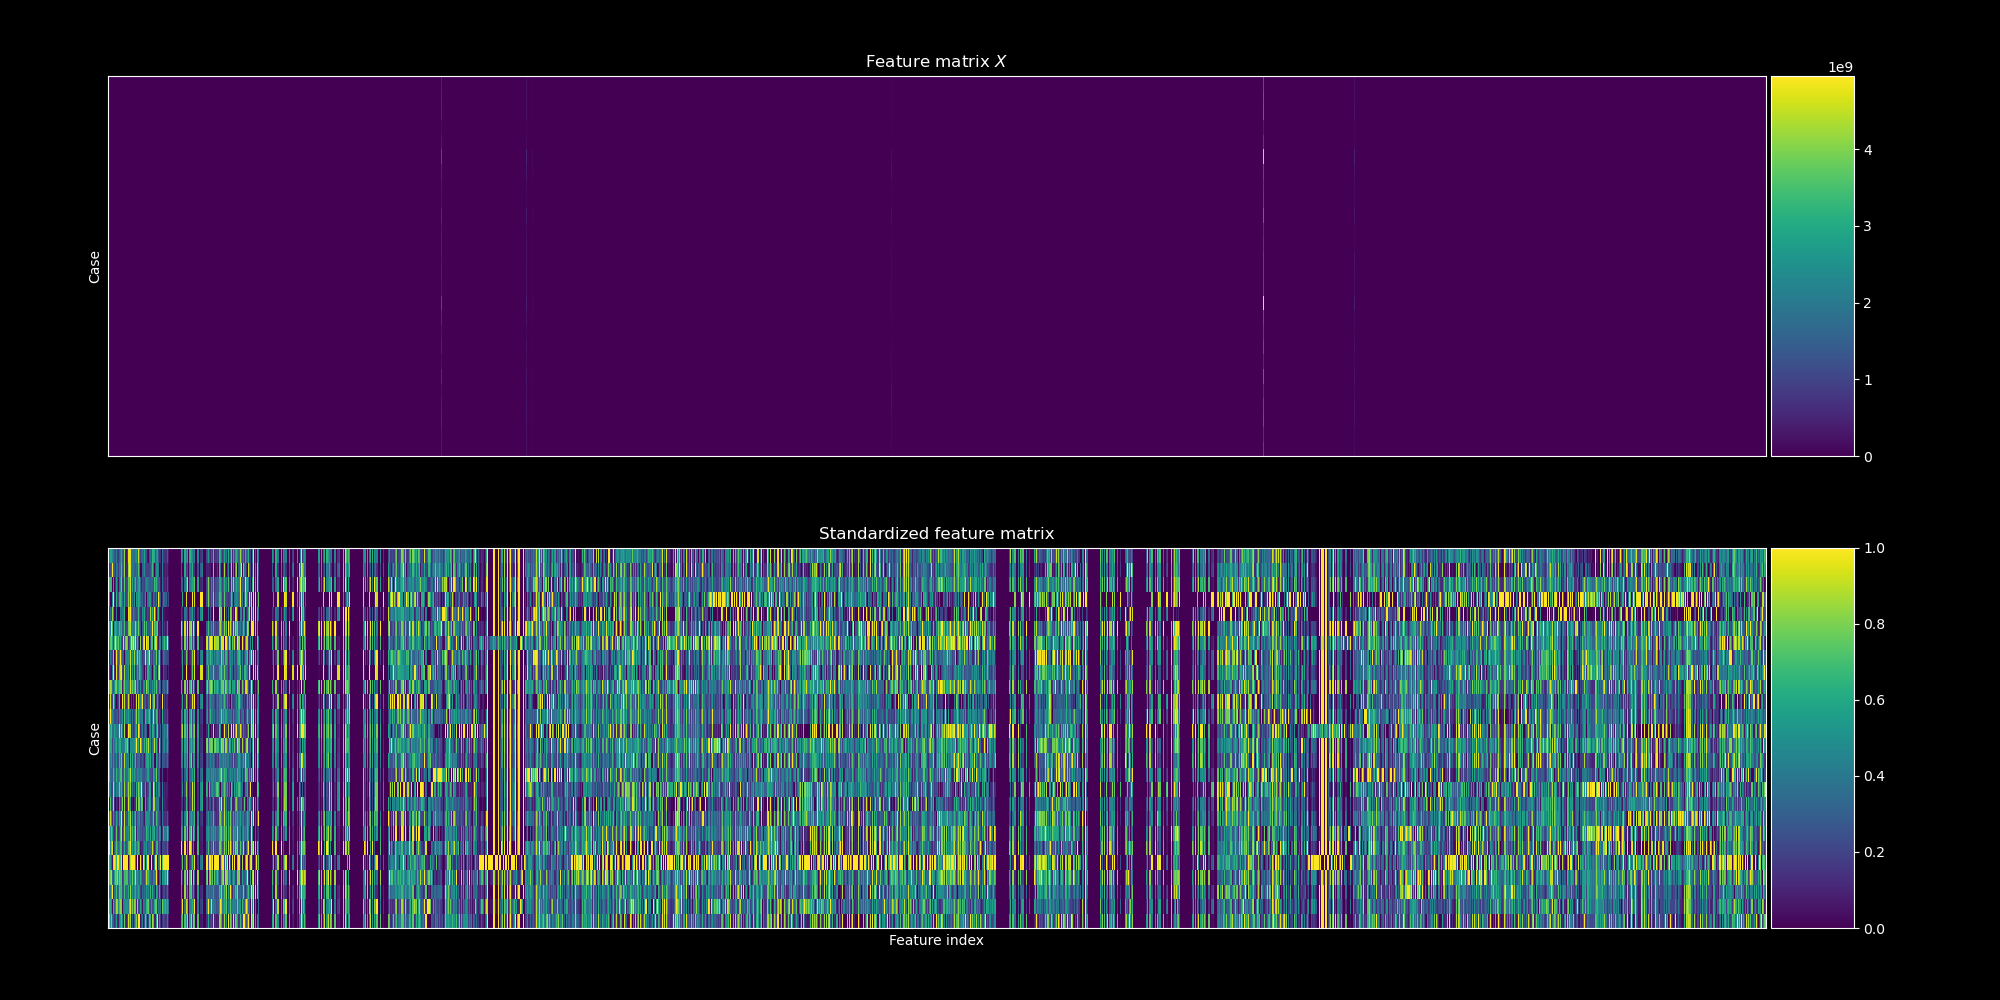

In [12]:
fig,ax = plt.subplots(2,1)
plt.style.use('dark_background')
im0 = ax[0].pcolor(X)
im1 = ax[1].pcolor(X_t)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('Feature index')
ax[0].set_ylabel('Case')
ax[1].set_ylabel('Case')
divider0 = make_axes_locatable(ax[0])
divider1 = make_axes_locatable(ax[1])
cax0 = divider0.append_axes('right',size='5%',pad=0.05)
fig.colorbar(im0,cax=cax0,orientation='vertical')
cax1 = divider1.append_axes('right',size='5%',pad=0.05)
fig.colorbar(im1,cax=cax1,orientation='vertical')
ax[1].set_title('Standardized feature matrix')
ax[0].set_title('Feature matrix $X$');

plt.tight_layout()
fig.set_size_inches(20,10)



In [13]:
Phi_y = np.vstack((per_change_train,X_t.T))
Phi_y = Phi_y.T
Phi_cov = np.cov(Phi_y.T)
Phi_corr = np.corrcoef(Phi_y.T)

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [14]:
nan_feats = 0
for kk in np.arange(feat_counts):
    if np.isnan(Phi_corr[kk,kk]):
        print('NaN detected at correlation matrix diagonal entry',kk, 'feature', keys[kk],'with covariance matrix value',Phi_cov[kk,kk])
        nan_feats = nan_feats+1



NaN detected at correlation matrix diagonal entry 111 feature exponential_firstorder_InterquartileRange with covariance matrix value 0.0
NaN detected at correlation matrix diagonal entry 124 feature exponential_firstorder_Variance with covariance matrix value 0.0
NaN detected at correlation matrix diagonal entry 126 feature exponential_glcm_ClusterProminence with covariance matrix value 0.0
NaN detected at correlation matrix diagonal entry 127 feature exponential_glcm_ClusterShade with covariance matrix value 0.0
NaN detected at correlation matrix diagonal entry 128 feature exponential_glcm_ClusterTendency with covariance matrix value 0.0
NaN detected at correlation matrix diagonal entry 129 feature exponential_glcm_Contrast with covariance matrix value 0.0
NaN detected at correlation matrix diagonal entry 130 feature exponential_glcm_Correlation with covariance matrix value 0.0
NaN detected at correlation matrix diagonal entry 131 feature exponential_glcm_DifferenceAverage with covari

In [15]:
with np.printoptions(threshold=np.inf):
    target_corr = np.sort(Phi_corr[:-1,Phi_corr.shape[1]-1])
    target_arg = np.argsort(Phi_corr[:-1,-1])
    high_corr = np.where(abs(target_corr[target_arg])>0.60)
 

print('Found',high_corr[0].__len__(),'highly correlated features')


Found 3 highly correlated features


In [16]:
high_corr_keys = []
for k in np.arange(0,high_corr[0].__len__()):
    print('Feature',keys[high_corr[0][k]],'has correlation',target_corr[target_arg[high_corr[0][k]]],'with UPDRS-III percent improvement')
    high_corr_keys.append(keys[high_corr[0][k]])
    

Feature wavelet-LHL_gldm_SmallDependenceHighGrayLevelEmphasis has correlation 0.7469968924417243 with UPDRS-III percent improvement
Feature wavelet-LHH_glrlm_LowGrayLevelRunEmphasis has correlation 0.6015624461701704 with UPDRS-III percent improvement
Feature wavelet-HLL_glcm_ClusterProminence has correlation -0.6038099523957688 with UPDRS-III percent improvement


In [17]:
X_thc = X_t[:,high_corr[0]]

In [18]:
high_corr[0][1]

2881

In [19]:
X_t.shape

(26, 3378)

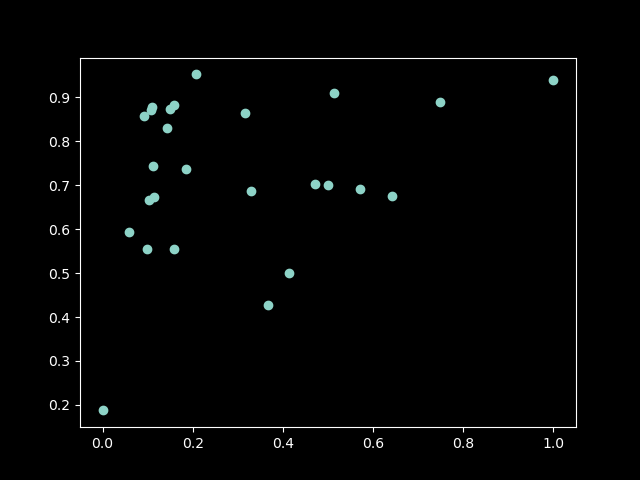

In [20]:
fig,ax = plt.subplots(1,1)
plt.scatter(X_t[:,high_corr[0][-1]],per_change_train)

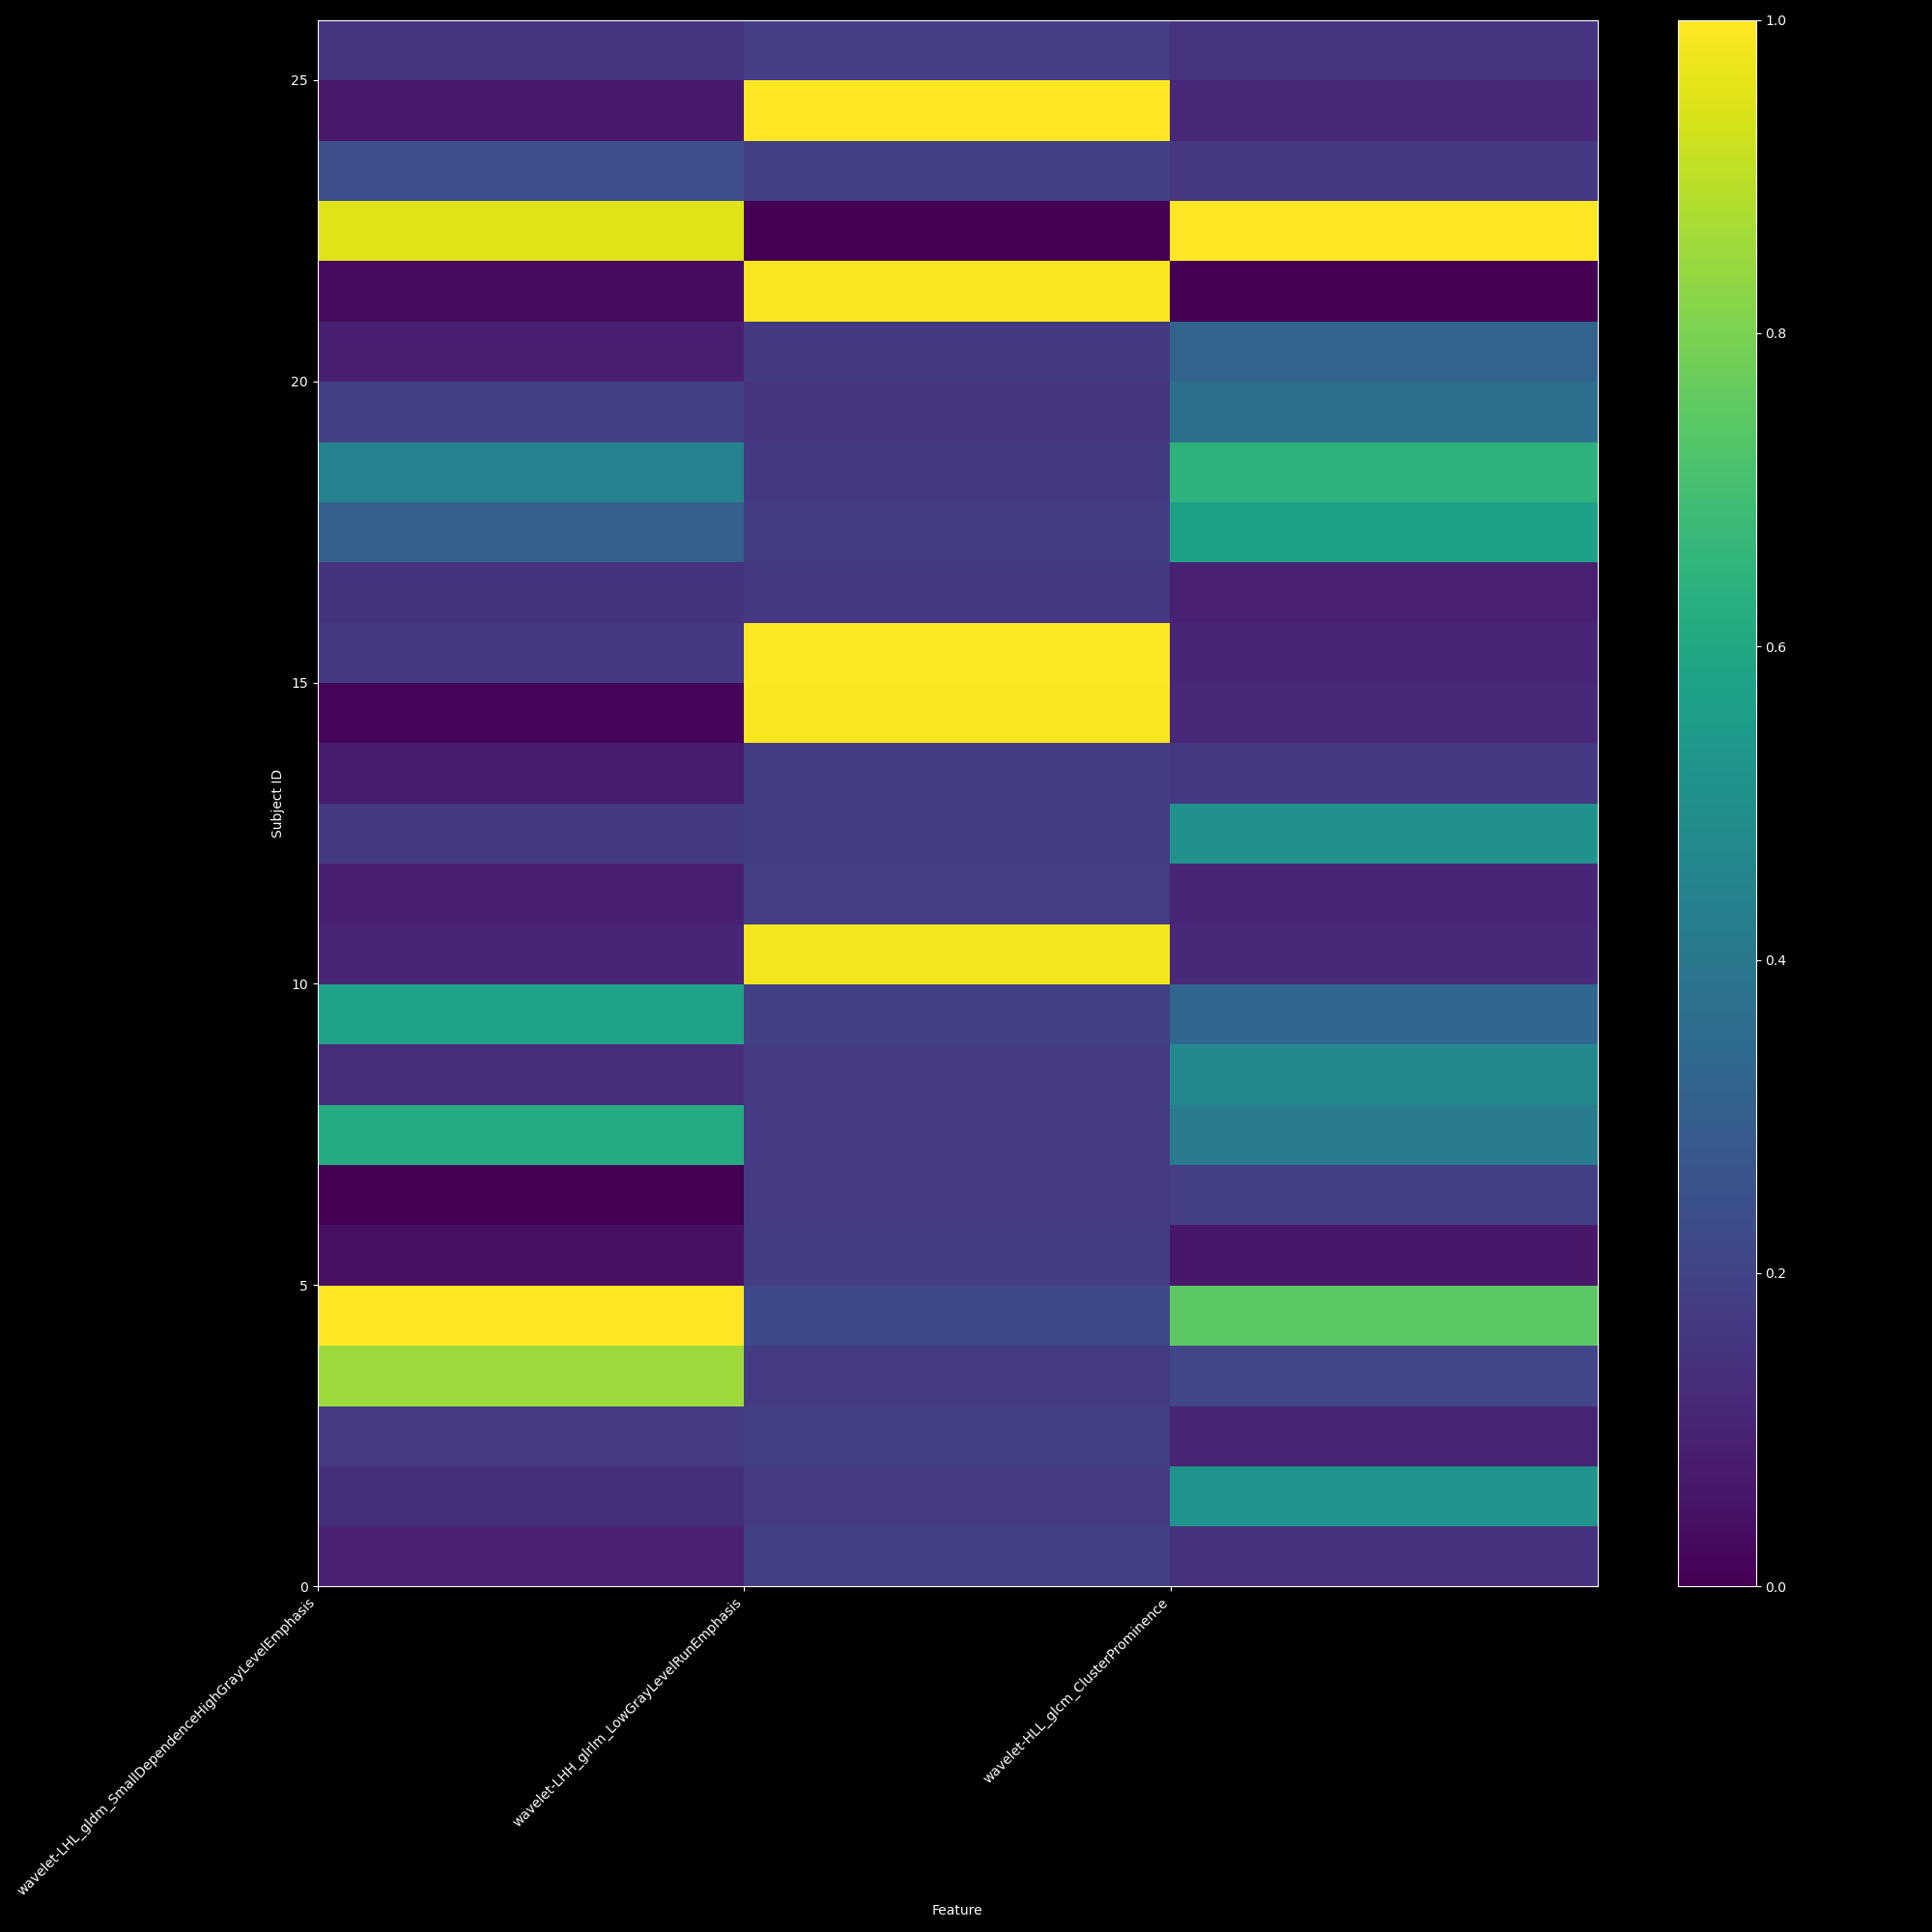

In [21]:
fig,ax = plt.subplots()
plt.style.use('dark_background')
im1 = ax.pcolor(np.squeeze(X_thc))
plt.xticks(np.arange(0,high_corr[0].__len__()),high_corr_keys,rotation=45,ha='right');
fig.colorbar(im1);
plt.xlabel('Feature')

plt.ylabel('Subject ID');
fig.set_size_inches(20,20)
fig.set_tight_layout(True)

In [22]:
tidx = 0
if retrain == 1:
    #fig,ax = plt.subplots(1,1)
    for j in complete_cases:
            # Remove the test case
            X_j = np.delete(np.squeeze(X_thc),tidx,0)
            per_change_train_j = np.delete(per_change_train,tidx,0)
            # Debug
            print('Excluding subject',str(j),'at index',str(tidx),'in target vector','from training feature vector of shape',str(X_t.shape),'by deleting row',str(tidx),'to create new training feature vector of shape',str(X_j.shape))
            if (sum(sum(np.isnan(X))))>0:
                print('NaN detected in feature vector')

            # Cross-validation for model selection
            cv = KFold((X_j.shape[0]-2))
            # Identify most important features
            # Do not assume data is centered,fit_intercept=True
            clf_in = RidgeCV(fit_intercept=True).fit(X_j,np.ravel(per_change_train_j))

            clf_alphas[tidx] = clf_in.alpha_
            ut[tidx] = clf_in.predict(X_thc[tidx,:].reshape(1,-1))
            print('Predicted percentage change of',ut[tidx],'for case',complete_cases[tidx],'with alpha',clf_in.alpha_)
            print('True percentage change',per_change_train[tidx])
            tidx = tidx+1


Excluding subject 1.0 at index 0 in target vector from training feature vector of shape (26, 3378) by deleting row 0 to create new training feature vector of shape (25, 3)
Predicted percentage change of 0.7144699899216024 for case 1.0 with alpha 10.0
True percentage change 0.8307692307692308
Excluding subject 2.0 at index 1 in target vector from training feature vector of shape (26, 3378) by deleting row 1 to create new training feature vector of shape (25, 3)
Predicted percentage change of 0.720001845331946 for case 2.0 with alpha 10.0
True percentage change 0.9090909090909091
Excluding subject 3.0 at index 2 in target vector from training feature vector of shape (26, 3378) by deleting row 2 to create new training feature vector of shape (25, 3)
Predicted percentage change of 0.7285362208622672 for case 3.0 with alpha 10.0
True percentage change 0.5555555555555556
Excluding subject 6.0 at index 3 in target vector from training feature vector of shape (26, 3378) by deleting row 3 to cr

In [23]:
tidx = 0
if retrain == 1:
    #fig,ax = plt.subplots(1,1)
    for j in complete_cases:
            # Remove the test case
            X_j = np.delete(np.squeeze(X_thc),tidx,0)
            per_change_train_j = np.delete(per_change_train,tidx,0)
            # Debug
            print('Excluding subject',str(j),'at index',str(tidx),'in target vector','from training feature vector of shape',str(X_t.shape),'by deleting row',str(tidx),'to create new training feature vector of shape',str(X_j.shape))
            if (sum(sum(np.isnan(X))))>0:
                print('NaN detected in feature vector')

            # Cross-validation for model selection
            cv = KFold((X_j.shape[0]-2))
            # Identify most important features
            # Do not assume data is centered,fit_intercept=True
            clf_in = RidgeCV(fit_intercept=True).fit(X_j,np.ravel(per_change_train_j))

            clf_alphas[tidx] = clf_in.alpha_
            ut[tidx] = clf_in.predict(X_thc[tidx,:].reshape(1,-1))
            print('Predicted percentage change of',ut[tidx],'for case',complete_cases[tidx],'with alpha',clf_in.alpha_)
            print('True percentage change',per_change_train[tidx])

            clf = Ridge(alpha=np.median(clf_alphas),fit_intercept=True).fit(X_j,np.ravel(per_change_train_j))
            ut_clf[tidx] = clf.predict(X_thc[tidx,:].reshape(1,-1))

            tidx = tidx+1

Excluding subject 1.0 at index 0 in target vector from training feature vector of shape (26, 3378) by deleting row 0 to create new training feature vector of shape (25, 3)
Predicted percentage change of 0.7144699899216024 for case 1.0 with alpha 10.0
True percentage change 0.8307692307692308
Excluding subject 2.0 at index 1 in target vector from training feature vector of shape (26, 3378) by deleting row 1 to create new training feature vector of shape (25, 3)
Predicted percentage change of 0.720001845331946 for case 2.0 with alpha 10.0
True percentage change 0.9090909090909091
Excluding subject 3.0 at index 2 in target vector from training feature vector of shape (26, 3378) by deleting row 2 to create new training feature vector of shape (25, 3)
Predicted percentage change of 0.7285362208622672 for case 3.0 with alpha 10.0
True percentage change 0.5555555555555556
Excluding subject 6.0 at index 3 in target vector from training feature vector of shape (26, 3378) by deleting row 3 to cr

In [24]:
if retrain == 1:
    with open('lasso_pred.npy','wb') as f:
        np.save(f,ut)
else:
    with open('lasso_pred.npy','rb') as f:
        ut = np.load(f)

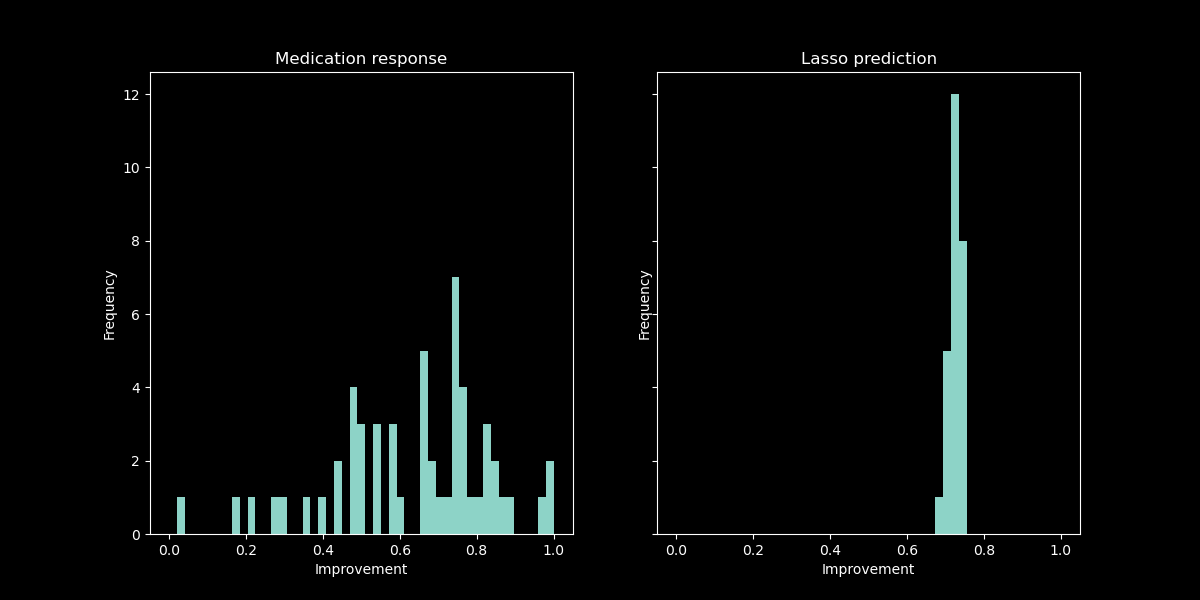

In [25]:
[fig,ax] = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].hist([lct_change],bins=np.linspace(0,1))
ax[0].set_title('Medication response')
ax[0].set_xlabel('Improvement')
ax[0].set_ylabel('Frequency')
ax[1].hist([ut],bins=np.linspace(0,1))
ax[1].set_title('Lasso prediction')
ax[1].set_xlabel('Improvement')
ax[1].set_ylabel('Frequency')
fig.set_size_inches(12,6)

Text(0.5, 0.98, 'UPDRS-III Improvement')

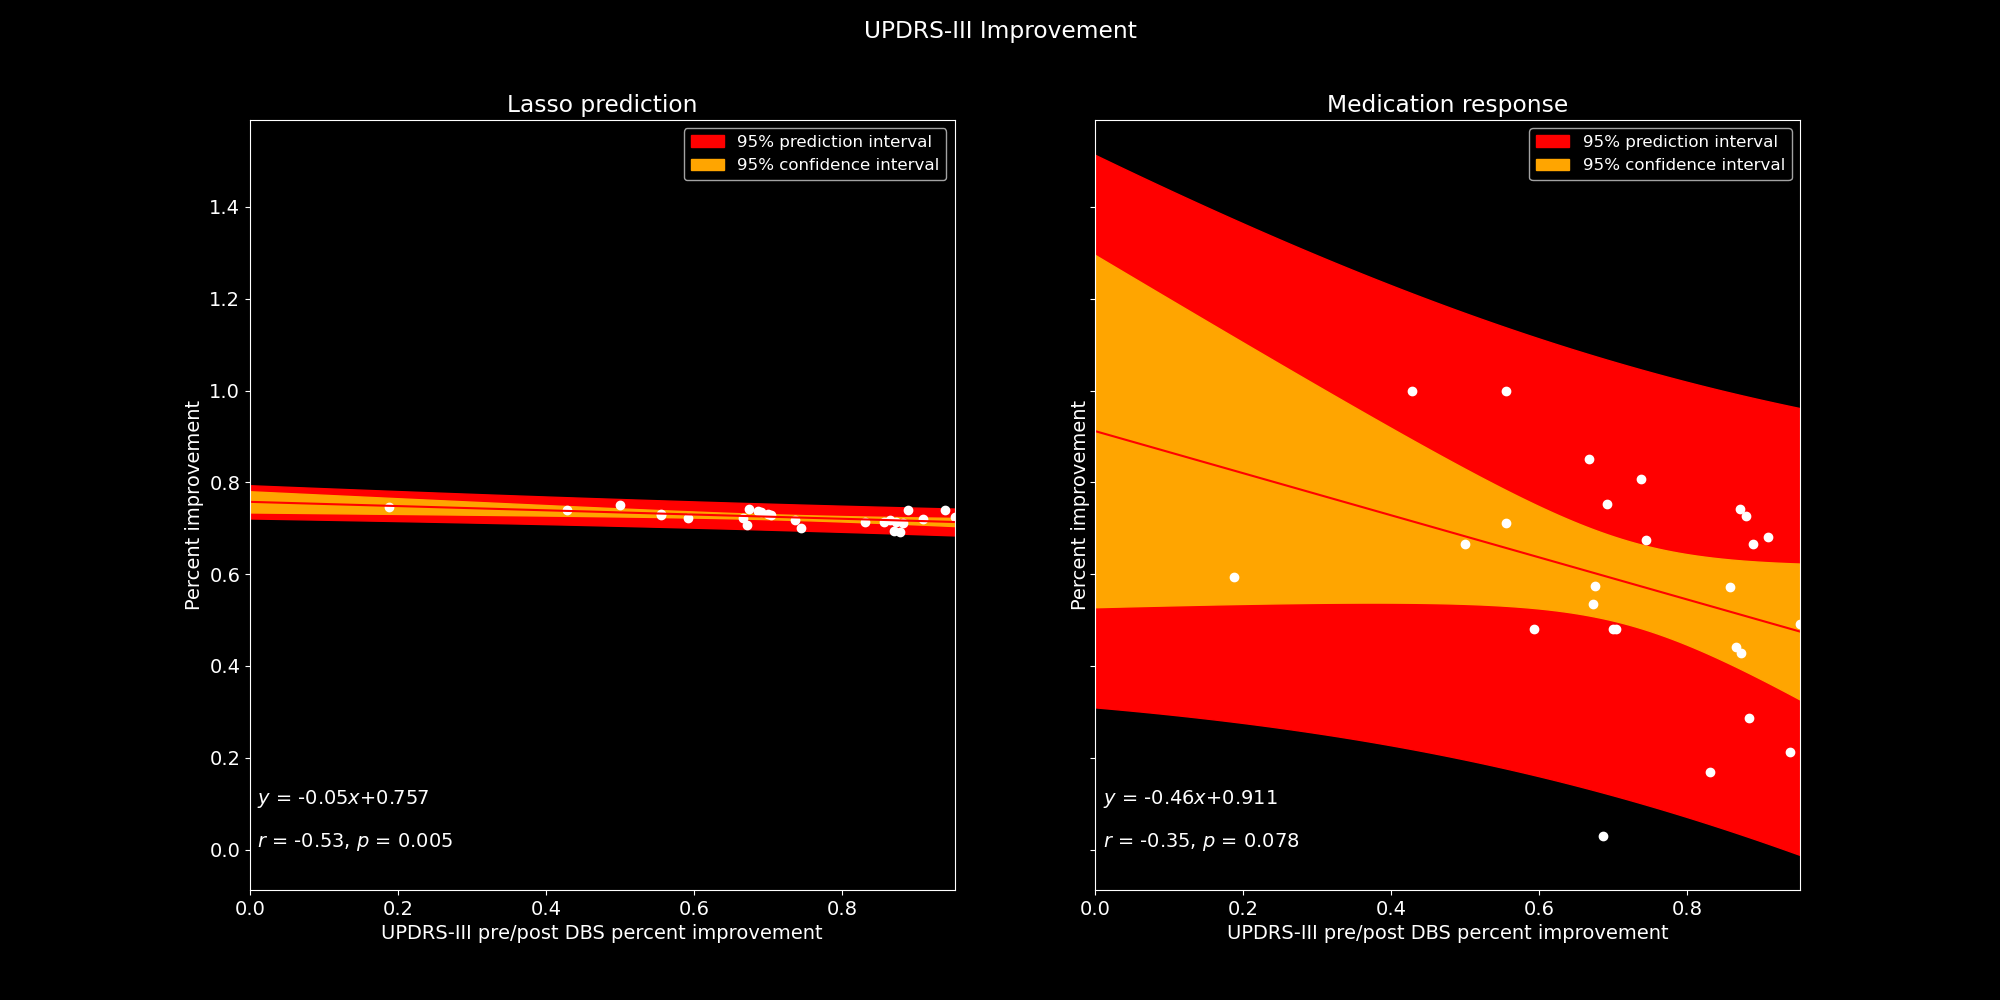

In [26]:
x = per_change[np.asarray(complete_cases).astype(int)-1]
y = ut_clf

slope,intercept = np.polyfit(x,y,1)  # linear model adjustment
y_model = np.polyval([slope,intercept],x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 2                             # number of parameters
dof = n-m                       # degrees of freedom
t = stats.t.ppf(0.975,dof)       # Students statistic of interval confidence
residual_ut = y-y_model
std_error = (np.sum(residual_ut**2)/dof)**(1/2)   # Standard deviation of the error

# Pearson's correlation coefficient
numerator = np.sum((x-x_mean)*(y-y_mean))
denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**.5
correlation_coef = numerator/denominator
r = correlation_coef
tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# p-value for 2-sided test
pv = 2*(1-stats.t.cdf(abs(tr), dof))
# # mean squared error
MSE = 1/n*np.sum((y-y_model)**2)

# to plot the adjusted model
x_line = np.linspace(0,np.max(x),100)
y_line = np.polyval([slope,intercept],x_line)

# confidence interval
ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5
# predicting interval
pi = t*std_error*(1+1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5  


plt.rcParams.update({'font.size': 14})
[fig,ax] = plt.subplots(1,2,sharex=True,sharey=True);

ax[0].plot(x,y,'o',color = 'white')
ax[0].plot(x_line,y_line,color = 'red')
ax[0].fill_between(x_line,y_line+pi,y_line-pi,color = 'red',label = '95% prediction interval')
ax[0].fill_between(x_line,y_line+ci,y_line-ci,color = 'orange',label = '95% confidence interval')

ax[0].set_xlabel('UPDRS-III pre/post DBS percent improvement')
ax[0].set_ylabel('Percent improvement')
ax[0].set_title('Lasso prediction')

ax[0].text(0.01,0.1,'$y$ = '+ str(np.round(slope,2))+'$x$'+'+'+str(np.round(intercept,3)),color='w')
ax[0].text(0.01,0.005,'$r$ = '+str(np.round(r,2))+', $p$ = '+str(round(pv,3)),color='w')

ax[0].margins(x=0)
fig.set_size_inches(20,10)
ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)


## Medication response
x = per_change[np.asarray(complete_cases).astype(int)-1]
y = lct_change[np.asarray(complete_cases).astype(int)-1]

# Fit and evaluate linear model
slope,intercept = np.polyfit(x,y,1)
y_model = np.polyval([slope,intercept],x)   

# Prepare correlation stats
x_mean = np.mean(x)
y_mean = np.mean(y)
# Sample size
n = x.size         
# Parameters assuming a normal distribution              
m = 2
# Degrees of freedom                            
dof = n-m
# Students statistic of interval confidence                      
t = stats.t.ppf(0.975,dof)      
# Standard deviation of the error
residual_lct = y-y_model
std_error = (np.sum(residual_lct**2)/dof)**(1/2)   

# Pearson's correlation coefficient
numerator = np.sum((x-x_mean)*(y-y_mean))
denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**.5
correlation_coef = numerator/denominator
r = correlation_coef
tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# p-value for 2-sided test
pv = 2*(1-stats.t.cdf(abs(tr), dof))
# # mean squared error
MSE = 1/n*np.sum((y-y_model)**2)

# to plot the adjusted model
x_line = np.linspace(0,np.max(x),100)
y_line = np.polyval([slope,intercept],x_line)

# confidence interval
ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5
# predicting interval
pi = t*std_error*(1+1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5  



ax[1].plot(x,y,'o',color = 'white')
ax[1].plot(x_line,y_line,color = 'red')
ax[1].fill_between(x_line,y_line+pi,y_line-pi,color = 'red',label = '95% prediction interval')
ax[1].fill_between(x_line,y_line+ci,y_line-ci,color = 'orange',label = '95% confidence interval')

ax[1].set_xlabel('UPDRS-III pre/post DBS percent improvement')
ax[1].set_ylabel('Percent improvement')
ax[1].set_title('Medication response')


ax[1].text(0.01,0.1,'$y$ = '+ str(np.round(slope,2))+'$x$'+'+'+str(np.round(intercept,3)),color='w')
ax[1].text(0.01,0.005,'$r$ = '+str(np.round(r,2))+', $p$ = '+str(round(pv,3)),color='w')

ax[1].margins(x=0)
fig.set_size_inches(20,10)
ax[1].legend(bbox_to_anchor=(1,1),fontsize=12)
fig.suptitle('UPDRS-III Improvement')


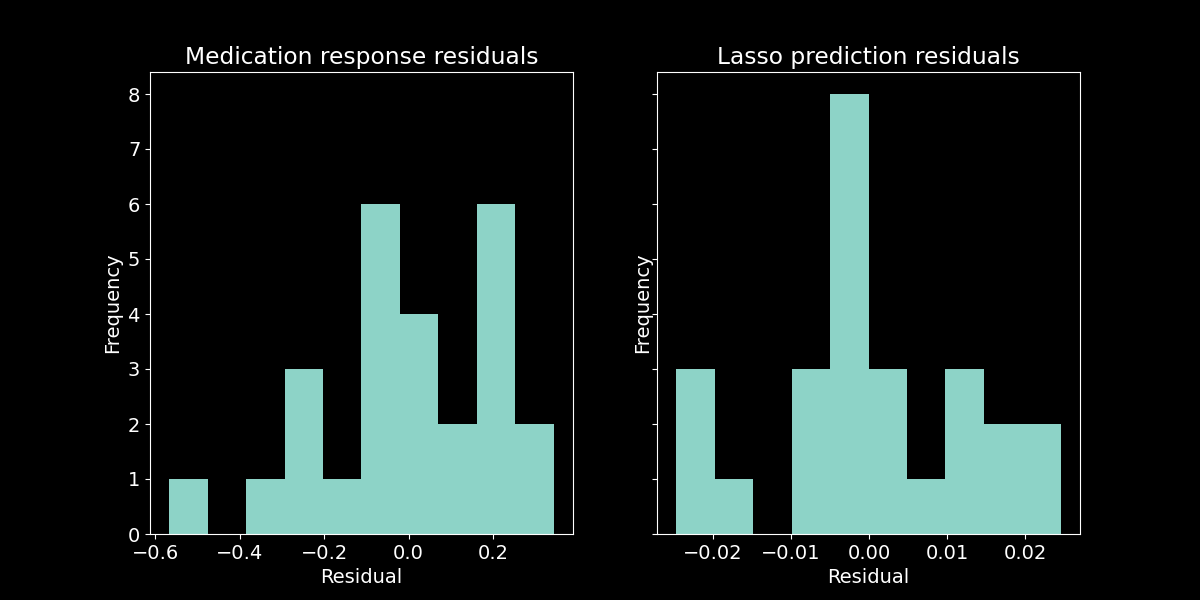

In [27]:
[fig,ax] = plt.subplots(1,2,sharex=False,sharey=True)
ax[0].hist([residual_lct])
ax[0].set_title('Medication response residuals')
ax[0].set_xlabel('Residual')
ax[0].set_ylabel('Frequency')
ax[1].hist([residual_ut])
ax[1].set_title('Lasso prediction residuals')
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Frequency')
fig.set_size_inches(12,6)